# Online Joint State and Parameters Estimation for Latent AR SSM
State space model
\begin{align*}
    &\mathbf{x}_t = A(\theta)\mathbf{x}_{t-1} + \mathbf{c}v_{t} \quad v_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = \mathbf{c}^{\top} \theta_t^{(0)} + w_t \quad w_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

Probabilistic model
\begin{align}
  p&(\mathbf{X}, \mathbf{y}, \theta, \gamma) = \underbrace{p(\mathbf{x}_0)p(\gamma_x)p(\gamma_y)p(\theta)}_{\text{priors}}\prod_{t=1}^{T}\underbrace{p(y_t|\mathbf{x}_t, \gamma_y)}_{\text{observation}}\underbrace{p(\mathbf{x}_t|\mathbf{x}_{t-1}, \theta, \gamma_x)}_{\text{state transition}}  \\
    p&(y_t|\mathbf{x}_t, \gamma_y) = \mathcal{N}\Bigl(y_t|\mathbf{x}_{t}, \gamma_y^{-1}\Bigr) \\
  p&(\mathbf{x}_t|\mathbf{x}_{t-1}, \theta, \gamma_x) = \mathcal{N}\Bigl(\mathbf{x}_t|A(\theta)\mathbf{x}_{t-1}, V\Bigr) \\
  p&(\mathbf{x}_0) = \mathcal{N}(\mathbf{x}_0|m_{\mathbf{x}_{0}}, V_{\mathbf{x}_{0}})  \\
  p&(\theta) = \mathcal{N}(\theta|m_{\theta}, V_{\theta}) \\
  p&(\gamma_x) = \Gamma(\gamma_x|\alpha_x, \beta_x) 
\end{align}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\top \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\top \quad \mathbf{c} = (1, 0, ..., 0)^{\top} \\ \\
    &A(\theta) = 
    \begin{bmatrix}
         \theta^{\top}  \\
         \mathbf{I}_{M-1} \quad \mathbf{0}
    \end{bmatrix}
    \, , \quad
    \mathbf{I}_M = 
    \begin{bmatrix}
        1_1 & 0 &  \dots & 0 \\ 
        0 & 1_2 &  \dots & 0 \\   
        \vdots &  \vdots & \ddots & \vdots \\
        0 & 0  & \dots & 1_{M}
    \end{bmatrix} \, ,\quad
      V= \begin{bmatrix}
            1/\gamma & 0 &\dots & 0 \\ 
            0 & \epsilon & \dots & 0 \\   
            \vdots & \vdots & \ddots & \vdots \\
             0 & 0 & \dots & \epsilon
    \end{bmatrix}
\end{align*}

In [3]:
using ProgressMeter
using LaTeXStrings
using Plots
using ForneyLab
using ForneyLab: unsafeCov, unsafeMean, unsafePrecision
using LAR.Node, LAR.Data

┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1317


In [4]:
using Random

Random.seed!(42)

# Define the order and data
ARorder = 2
n_samples = 1000
# AR data
v_x = 1.0 # process noise variance
coefs, dataAR = generateAR(n_samples, ARorder, nvar=v_x, stat=true)
x = [x[1] for x in dataAR]

v_y = 2.0 # measurement noise variance
# Observations

y = [x[1] + sqrt(v_y)*randn() for x in dataAR];

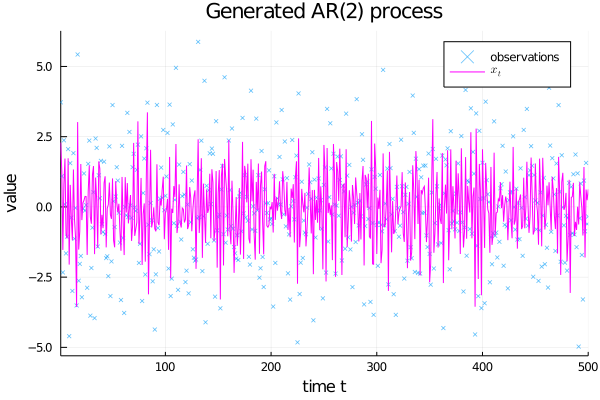

In [5]:
from = 1; upto = 500;
plot(xlims=(from, upto))
scatter!(y, markershape = :xcross, markeralpha = 0.6, markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(x, color=:magenta, label=L"x_t", title="Generated AR($ARorder) process")

In [11]:
# Creating the graph
graph = FactorGraph()
# declare priors as random variables
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ_t, dims=(ARorder,)),
                              placeholder(:w_θ_t, dims=(ARorder, ARorder)))

@RV x_t_prev ~ GaussianMeanPrecision(placeholder(:m_x_t_prev, dims=(ARorder,)),
                                     placeholder(:w_x_t_prev, dims=(ARorder, ARorder)))

@RV w_x ~ Gamma(placeholder(:a_w), placeholder(:b_w))
@RV x_t ~ Autoregressive(θ, x_t_prev, w_x)

c = zeros(ARorder); c[1] = 1;
@RV y_t ~ GaussianMeanPrecision(dot(c, x_t), placeholder(:w_y_t))

# Placeholder for data
placeholder(y_t, :y_t)

Variable(:y_t, Edges:
Edge belonging to variable y_t: ( gaussianmeanprecision_3.i[out] )----( placeholder_y_t.i[out] ).
)

In [12]:
# Specify recognition factorization
q = PosteriorFactorization([x_t, x_t_prev], θ, w_x,
                           ids=[:XStruct :Θ :W_x])

algo = messagePassingAlgorithm(free_energy=true)
src_code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(src_code))

freeEnergy (generic function with 1 method)

In [13]:
m_θ_0 = zeros(ARorder)
w_θ_0 = diageye(ARorder)
m_x_prev_0 = zeros(ARorder)
w_x_prev_0 = diageye(ARorder)
a_w_0 = 1.0
b_w_0 = 1.0


m_x = Vector{Vector{Float64}}(undef, length(y))
w_x = Vector{Array{Float64, 2}}(undef, length(y))
m_θ = Vector{Vector{Float64}}(undef, length(y))
w_θ = Vector{Array{Float64, 2}}(undef, length(y))
a_w = Vector{Float64}(undef, length(y))
b_w = Vector{Float64}(undef, length(y))
m_u = Vector{Float64}(undef, length(y))
v_u = Vector{Float64}(undef, length(y))

vmp_iter = 10
fe = Array{Float64}(undef,length(y),vmp_iter)

marginals = Dict()
@showprogress for t in 1:n_samples
    
    global m_θ_0, w_θ_0, m_x_prev_0, w_x_prev_0, a_w_0, b_w_0
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ_0, w=w_θ_0)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_prev_0, w=w_x_prev_0)
    marginals[:w_x] = ProbabilityDistribution(Univariate, Gamma, a=a_w_0, b=b_w_0)
    for i = 1:vmp_iter
        data = Dict(:y_t => y[t],
                    :w_y_t => v_y^-1,
                    :m_θ_t => m_θ_0,
                    :w_θ_t => w_θ_0,
                    :m_x_t_prev => m_x_prev_0,
                    :w_x_t_prev => w_x_prev_0,
                    :a_w => a_w_0,
                    :b_w => b_w_0)
        Base.invokelatest(stepXStruct!, data, marginals)
        Base.invokelatest(stepΘ!, data, marginals)
        Base.invokelatest(stepW_x!, data, marginals)
        fe[t, i] = Base.invokelatest(freeEnergy, data, marginals)

    end
    m_θ[t] = unsafeMean(marginals[:θ])
    w_θ[t] = unsafePrecision(marginals[:θ])
    m_x[t] = unsafeMean(marginals[:x_t_x_t_prev])[1:ARorder]
    w_x[t] = unsafePrecision(marginals[:x_t_x_t_prev])[1:ARorder, 1:ARorder]
    a_w[t] = marginals[:w_x].params[:a]
    b_w[t] = marginals[:w_x].params[:b]
    m_θ_0 = m_θ[t]
    w_θ_0 = w_θ[t]
    m_x_prev_0 = m_x[t]
    w_x_prev_0 = w_x[t]
    a_w_t_min = a_w[t]
    b_w_t_min = b_w[t]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [14]:
println("Coefs")
println("real = ", coefs)
println("estimated mean = ", unsafeMean(marginals[:θ]))
println("===============")
println("Noise")
println("real variance = ", v_x)
println("estimated variance = ", unsafeMean(marginals[:w_x])^-1)

Coefs
real = [-0.5560268761463861, -0.444383357109696]
estimated mean = [-0.35174038784085143, -0.31696689524066923]
Noise
real variance = 1.0
estimated variance = 0.8917092592791724


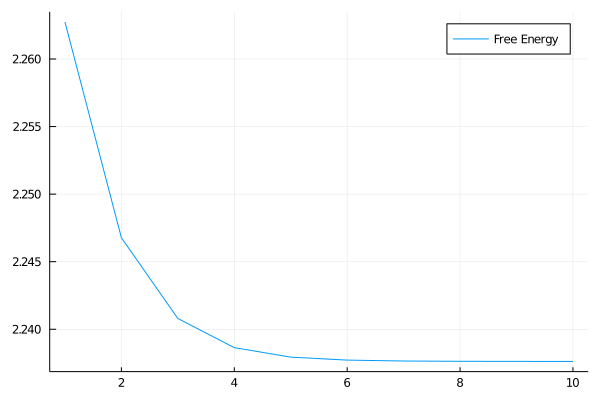

In [15]:
FE = sum(fe[:, :], dims=1)'/n_samples
plot(FE, label="Free Energy")

In [16]:
m_x = [x[1] for x in m_x]; w_x = [x[1] for x in w_x];

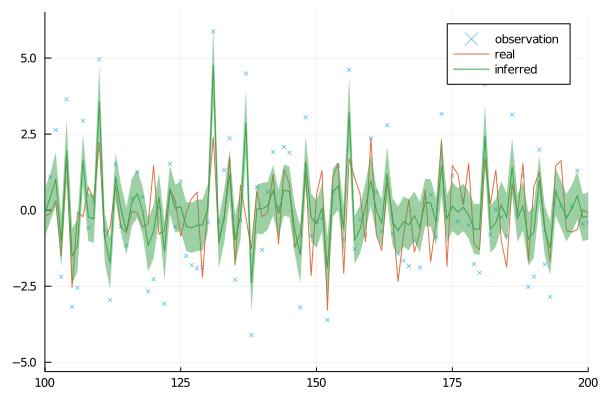

In [17]:
scatter(y, markershape = :xcross, markeralpha = 0.6, markersize = 2, label="observation")
plot!(x, label="real")
plot!(m_x, ribbon=sqrt.(inv.(w_x)), label="inferred", xlims=(100, 200))